## iPyLeaflet
[ipyleaflet](https://github.com/ellisonbg/ipyleaflet) is a bridge between jupyter notebooks and the [leaflet](http://leafletjs.com/)  javascript library for drawing maps.

ipyleaflet comes with a few examples notebooks (this notebook was derived from one) but very little documentation,
for more documentation read the [Leaflet IPA](http://leafletjs.com/reference.html)

For installation directions, see the README on [ipyleaflet](https://github.com/ellisonbg/ipyleaflet)

In [1]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl
)

## Visualizing the distribution of the observations

## Load the required libraries

In [2]:
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

In [3]:
import findspark
findspark.init()

from pyspark import SparkContext
#sc.stop()
sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/computeStats.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

In [4]:
import sys
sys.path.append('./lib')

import numpy as np
from numpy_pack import packArray,unpackArray
from computeStats import computeOverAllDist, STAT_Descriptions

In [5]:
### Read the data frame from pickle file

data_dir='../../Data/Weather'
file_index='SBBBSBSS'
meas='PRCP'

from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
print('keys from STAT=',STAT.keys())

#!ls -ld $data_dir/*.parquet

#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)

df=sqlContext.read.parquet(filename)
print(df.count())
df.show(2)

('keys from STAT=', ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP'])
2514
+-------------------+-----------------+------------------+---------+--------+--------+---------+-----------+------------------+-----------------+------------------+------------------+-----------+---------+------+--------------------+------+
|            coeff_1|          coeff_2|           coeff_3|elevation|   label|latitude|longitude|measurement|             res_1|            res_2|             res_3|          res_mean|    station|total_var|undefs|              vector|  year|
+-------------------+-----------------+------------------+---------+--------+--------+---------+-----------+------------------+-----------------+------------------+------------------+-----------+---------+------+--------------------+------+
|-40.788848414307246|-9.42137828275328| 48.74452834983202|   2226.9|SBBBSBSS| 46.8333|   -110.7|       PRCP|0.9993542945122948|0.999224652865477|0.9953442612007845|0.8617196779629716|USC00244663| 729122

In [6]:
#extract longitude and latitude for each station
feature='coeff_1'
sqlContext.registerDataFrameAsTable(df,'weather')
Query="SELECT station, latitude,longitude,elevation,%s FROM weather"%feature
print(Query)
df1 = sqlContext.sql(Query)
df1.show(4)

SELECT station, latitude,longitude,elevation,coeff_1 FROM weather
+-----------+--------+---------+---------+-------------------+
|    station|latitude|longitude|elevation|            coeff_1|
+-----------+--------+---------+---------+-------------------+
|USC00244663| 46.8333|   -110.7|   2226.9|-40.788848414307246|
|USC00244979| 47.0111|-109.2261|   1532.5|  4.764905592363118|
|USC00244522| 47.3144|-106.9103|    798.6|-16.935583101066385|
|USC00248927| 46.5425|-110.9042|   1572.8| -5.889760899842937|
+-----------+--------+---------+---------+-------------------+
only showing top 4 rows



In [7]:
df2=df1.groupby(['station','latitude','longitude','elevation']).agg({"station": "count", feature: "mean"})
pdf=df2.toPandas()
pdf.sort_values(by=['station'],inplace=True)
pdf.head(1000)

,station,latitude,longitude,elevation,count(station),avg(coeff_1)
67,US1MTCH0002,47.5851,-110.7890,1035.7,4,111.973533
50,US1MTCH0006,47.5974,-110.0075,962.3,1,65.536650
61,US1MTFG0003,46.8201,-109.7935,1301.8,2,189.962261
32,US1MTMH0004,46.4779,-108.4165,959.5,5,126.107181
74,US1MTMH0006,46.3958,-108.5489,1010.4,1,448.709175
12,US1MTMH0012,46.5618,-108.4670,1090.0,2,152.317553
52,US1MTMH0013,46.5992,-107.8672,894.0,2,176.370688
81,US1MTRB0008,46.5446,-107.7627,963.2,1,324.037068
5,USC00241225,46.9167,-107.2667,1005.8,1,-102.300027
80,USC00241231,47.4647,-107.3114,906.5,55,-6.448368


In [8]:
df2.groupBy().min().show()

+-------------+--------------+--------------+-------------------+-------------------+
|min(latitude)|min(longitude)|min(elevation)|min(count(station))|  min(avg(coeff_1))|
+-------------+--------------+--------------+-------------------+-------------------+
|      46.3619|     -110.9042|        -999.9|                  1|-154.20507320071698|
+-------------+--------------+--------------+-------------------+-------------------+



In [9]:
df2.groupBy().max().show()

+-------------+--------------+--------------+-------------------+-----------------+
|max(latitude)|max(longitude)|max(elevation)|max(count(station))|max(avg(coeff_1))|
+-------------+--------------+--------------+-------------------+-----------------+
|      47.8056|        -106.7|        2468.9|                110|448.7091748310809|
+-------------+--------------+--------------+-------------------+-----------------+



In [10]:
#define a mapping from the range of the value to hex colors.
from matplotlib.colors import rgb2hex
_avg='avg(%s)'%feature
_min=pdf[_avg].min()
_max=pdf[_avg].max()
_min,_max

import pylab as plt
cmap=plt.get_cmap('jet')
def get_color(val):
    x=(val-_min)/(_max-_min)
    return(rgb2hex(cmap(x)[:3]))

get_color(1000.)

u'#800000'

## Map

In [11]:
min_lat,max_lat,min_long,max_long = box = ( 46.3619, 47.6422, -110.9042, -106.7)


In [12]:
firstGroup=[u'USS0010C06S', u'US1MTCH0006', u'USC00249047', u'USC00244120',
       u'USS0010C15S', u'USW00004140', u'USC00246902', u'USS0010C23S',
       u'USC00245761', u'USC00248156', u'USC00247714', u'US1MTMH0012',
       u'USC00244663', u'USC00247273', u'USC00242537', u'USC00248511',
       u'USC00242012', u'USC00247943', u'USC00245873', u'USC00242886',
       u'USC00243445', u'USC00245193', u'USC00245596', u'USC00243939',
       u'USC00243731', u'USS0009C01S', u'USC00243947', u'USC00246007',
       u'USC00248495', u'USC00249054', u'USC00248152', u'USC00243013',
       u'USC00249033', u'USC00247234', u'US1MTFG0003', u'USC00243455',
       u'USC00244381', u'USC00243865', u'USW00024036', u'USC00243389',
       u'USC00248161', u'USC00248521', u'USC00241231', u'USC00243736',
       u'USC00245860', u'USC00244978', u'USC00245387', u'US1MTMH0004',
       u'US1MTMH0013', u'USC00246510', u'USC00245872', u'USC00245876',
       u'US1MTCH0002', u'USC00243556', u'USC00242783', u'USC00248498',
       u'USS0010C09S', u'USW00094051', u'USC00244538', u'USC00241565',
       u'USC00247228', u'USC00248493', u'USC00247858', u'USC00247864',
       u'USC00242347', u'USC00247540', u'USC00247195', u'USC00244386',
       u'USC00248930', u'USC00248964', u'USC00244143', u'US1MTRB0008',
       u'USC00244384', u'USC00249048', u'USC00244522', u'USC00245235',
       u'USC00249192', u'USC00247214', u'USC00243463', u'USC00246001']
secondGroup=[u'USC00244979', u'USC00244368', u'USC00244133', u'USC00243727',
       u'USC00241225', u'USC00248933', u'US1MTMH0006', u'USC00246900',
       u'USC00247263', u'USC00244545', u'USC00244007', u'USC00246008',
       u'USC00241252', u'USC00244954', u'USC00247342', u'USC00245390',
       u'USC00248927', u'USC00241880', u'USC00244193']

stationSet=set(['US1MTMH0006', 'US1MTMH0012', 'US1MTMH0013', 'US1MTRB0008', 'USC00241225'])

In [17]:
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]
zoom = 9

m = Map(default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

r = Rectangle(bounds=[[min_lat,min_long],[max_lat,max_long]], weight=5, fill_opacity=0.0)
m += r

lat_margin=(max_lat-min_lat)/4
long_margin=(max_long-min_long)/4
circles = []
for index,row in pdf.iterrows():
    _lat=row['latitude']
    _long=row['longitude']
    _count=row['count(station)']
    _coef=row[_avg]
    # taking sqrt of count so that the  area of the circle corresponds to the count
    if row['station'] in firstGroup:      
        c = Circle(location=(_lat,_long), radius=int(3000), weight=1,
                color='#2c7fb8', opacity=0.8, fill_opacity=0.4,
                fill_color='#c7e9b4')
    else
        c = Circle(location=(_lat,_long), radius=int(3000), weight=1,
                color='#2c7fb8', opacity=0.8, fill_opacity=0.4,
                fill_color='#7fcdbb')
    circles.append(c)
    m.add_layer(c)   
        
    
    c = Circle(location=(_lat,_long), radius=int(300*np.sqrt(_count+0.0)), weight=1,
            color='#F00', opacity=0.8, fill_opacity=0.4,
            fill_color=get_color(_coef))
    circles.append(c)
    m.add_layer(c)
m    

### excercises:
* Add a legend that relates the colors to values.
* Leaflet supports a variety of maps. See if you can get a topographical map as the background.

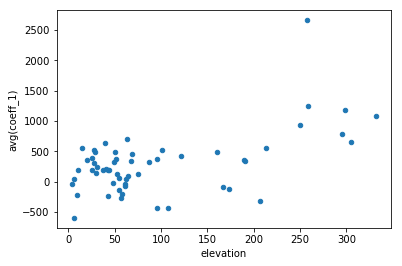

In [16]:
%matplotlib inline
pdf.plot.scatter(x='elevation',y='avg(coeff_1)');

In [21]:
RDD1=sc.parallelize(["spark  basics", "spark big  data analysis", "spring"]) 
RDD2=sc.parallelize(["spark using pyspark", "big data"])
 
RDD1.subtract(RDD2).collect()

['spark big  data analysis', 'spring', 'spark  basics']